<a href="https://colab.research.google.com/github/Yyzhang2000/learning-generative-models/blob/main/vae/02_conditional_vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

from tqdm.autonotebook import trange
import random

In [55]:
DATA_PATH = "./data"
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(DATA_PATH, transform=transform, download=True)
test_dataset  = MNIST(DATA_PATH, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoder Model

In [57]:
class Encoder(nn.Module):
    def __init__(
            self,
            in_dim = 28 * 28,
            hidden_dim = 512,
            latent_dim = 8
    ):
        super().__init__()

        self.ln1 = nn.Linear(in_dim, hidden_dim, bias = False)
        self.ln2 = nn.Linear(hidden_dim, hidden_dim, bias = False)

        self.mean = nn.Linear(hidden_dim, latent_dim, bias = False)
        self.log_var = nn.Linear(hidden_dim, latent_dim)

        self.act = nn.LeakyReLU(0.2)

    def forward(self, x):
        hidden = self.act(self.ln2(self.act(self.ln1(x))))

        mean = self.mean(hidden)
        log_var = self.log_var(hidden)

        return mean, log_var

In [58]:
class Decoder(nn.Module):
    def __init__(self, out_dim=28 * 28, hidden_dim=512, latent_dim = 8):
        super().__init__()

        self.ln1 = nn.Linear(latent_dim, hidden_dim, bias = False)
        self.ln2 = nn.Linear(hidden_dim, hidden_dim, bias = False)
        self.output = nn.Linear(hidden_dim, out_dim, bias = False)

        self.act = nn.LeakyReLU(0.2)

    def forward(self, z):
        hidden = self.act(self.ln2(self.act(self.ln1(z))))

        x_hat = F.sigmoid(self.output(hidden))

        return x_hat

In [59]:
class VAE(nn.Module):
    def __init__(self,num_classes = 10 ,latent_dim = 8):
        super().__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

        self.label_embedding = nn.Embedding(num_classes, latent_dim)
        self.num_classes = num_classes


    def encode(self, x):
        mean, log_var  = self.encoder(x)
        return mean, log_var

    def decode(self, z, y):
        z += self.label_embedding(y)
        return self.decoder(z)

    def reparameterization(self, mean, var):
        eps = torch.rand_like(var).to(mean.device)
        z = mean + var * eps
        return z


    def forward(self, x, y):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))


        x_hat = self.decode(z, y)
        return x_hat, mean, log_var

    def generate(self, y=None):
        if not y:
            y = random.randint(0, self.num_classes)
            y = torch.tensor([y]).unsqueeze(0)

        self.eval()
        with torch.no_grad():
            z = torch.randn(1, 1, 8)
            sample = self.decode(z, y)

        return sample


In [60]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [61]:
def loss_function(x, x_hat, mean, log_var):
    construction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    KL_Div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return construction_loss + KL_Div

In [62]:
model.train()
losses = []
for epoch in trange(50):
    for x, y in train_loader:
        x = x.flatten(1).to(device)
        y = y.to(device)

        x_hat, mean, log_var = model(x, y)
        loss = loss_function(x, x_hat, mean, log_var)

        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]

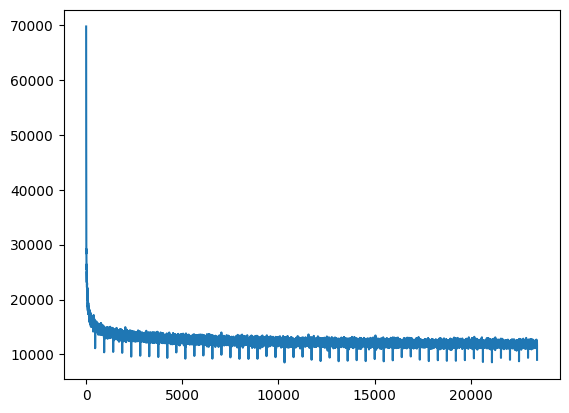

In [63]:
plt.plot(losses);

# Sampling from the Generative Models

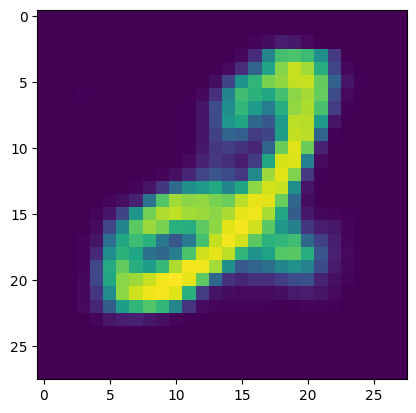

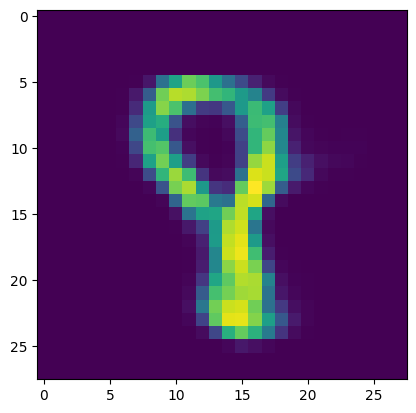

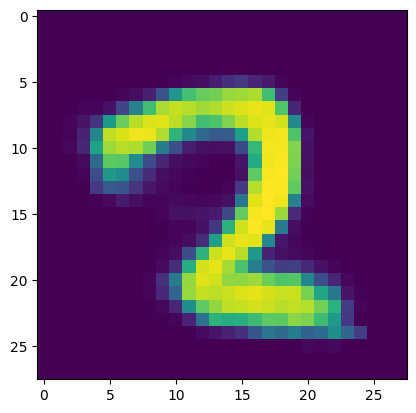

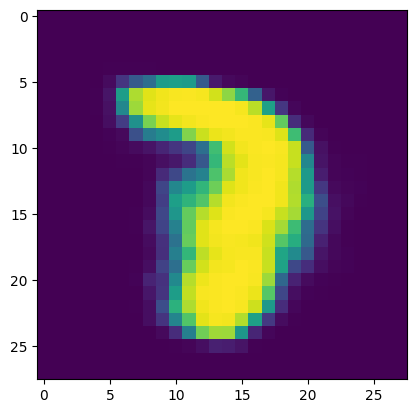

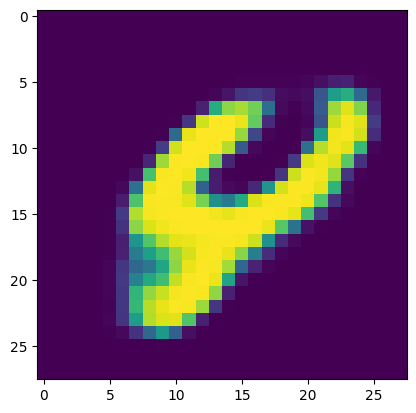

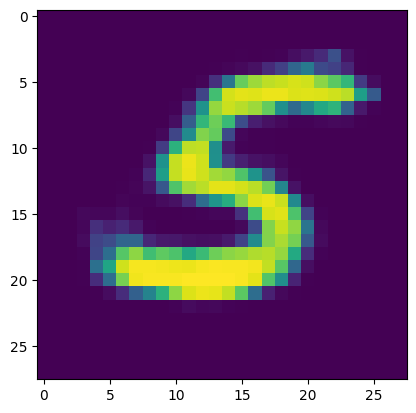

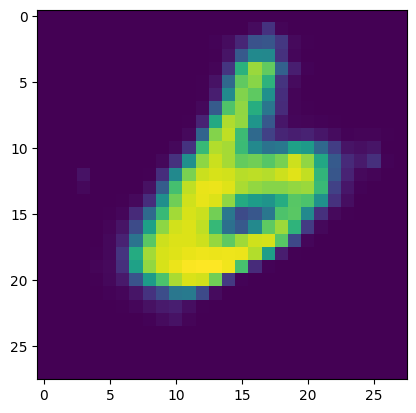

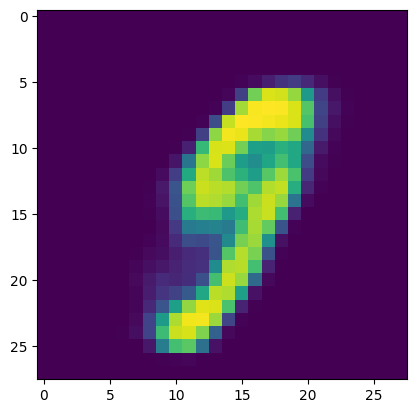

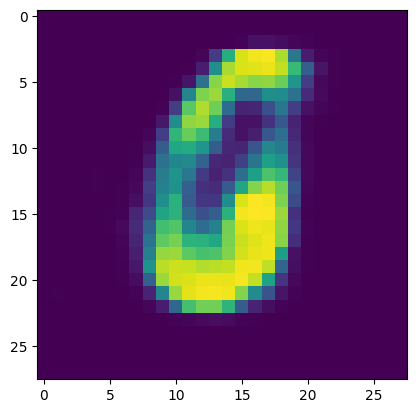

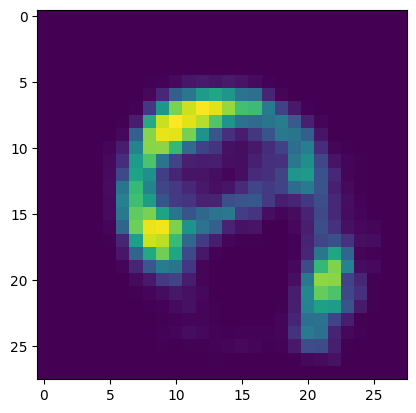

In [64]:
model.to('cpu')
for i in range(10):
    sample = model.generate(y = torch.tensor([i]).unsqueeze(0))
    sample = sample.reshape(28, 28).squeeze(0).detach().cpu().numpy()

    f, axarr = plt.subplots(1)
    axarr.imshow(sample)